# **Buisness Problem Statement**<br>
HELP International is an international humanitarian NGO. After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. Our job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country and need to suggest the countries which the CEO needs to focus on the most.

The steps are broadly:
1. Read and understanding the data
2. Exploratory Data Analysis  with univariate and bivariate analysis
3. Prepare the data for clustering
4. Modelling
5. Visualise the clusters
6. Cluster Profiling

# 1. Read and understanding the data

Let's start by importing the required libraries.

In [1]:
# warnings for filtering 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn classes required for K Means Clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# importing scipy classes required for Hierarchial clustering 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# shape of the dataFrame
df.shape

(167, 10)

In [4]:
# basics of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# describing the dataframe 
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Data cleaning and Manipulation

In [6]:
# checking for missing values

round(100*(df.isnull().sum())/len(df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

`INFERENCE:`There are no missing values in the data, hence no need to clean the data.

In [7]:
# dropping duplicate data

df =df.drop_duplicates()
df.shape

(167, 10)

`INFERENCE:` No duplicate data is found in the dataset

In [8]:
# Exports, Imports and health columns are given as %age of the GDP per capita.
# Thus Converting to absolute values mutiplying by gdpp and multiplying by 100.

df['exports'] = df['exports']* df['gdpp']/100
df['health'] = df['health']* df['gdpp']/100
df['imports'] = df['imports']* df['gdpp']/100

In [9]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


# 2. Exploratory Data Analysis 

## 2.1 Univariate Analysis

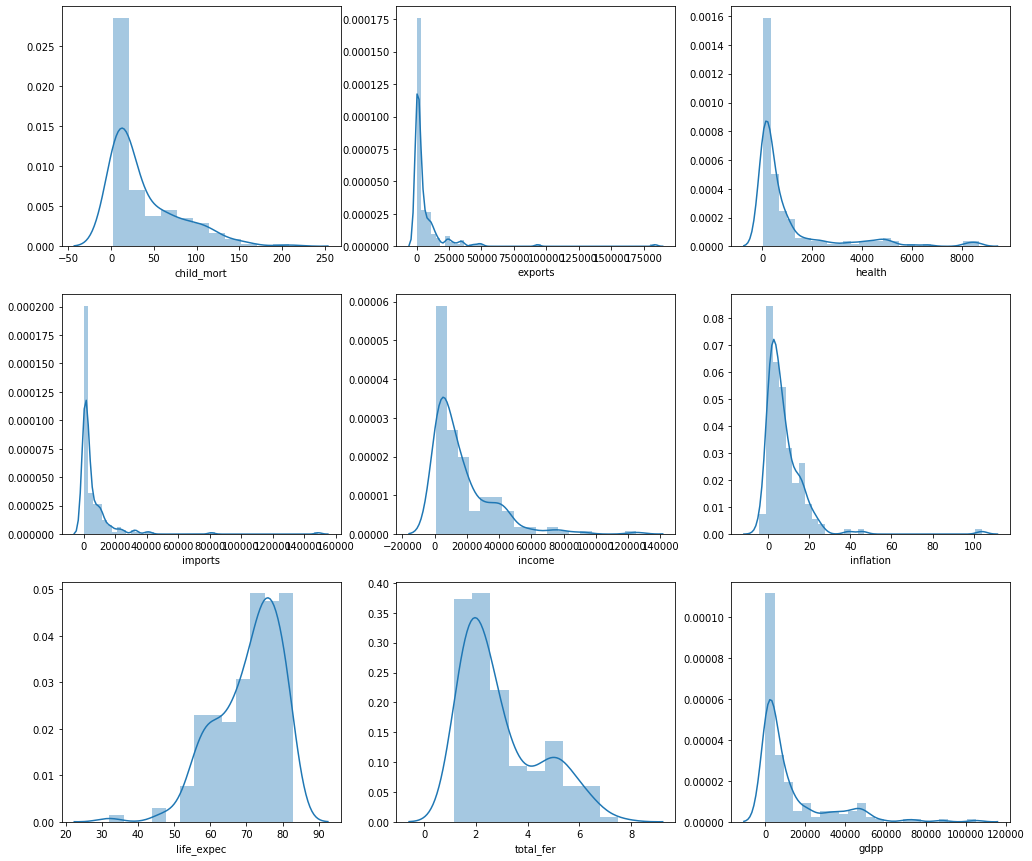

In [10]:
# Plot distribution graph 

plt.figure(figsize=(17,15))
f= df.columns[1:]
for i in enumerate(f):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(df[i[1]])


`INFERENCE`
- From the above analysis, we decided that we will be using CHILD_MORT, INCOME and GDPP for cluster profiling but we will use all the columns for Clustering.

- All curves except Life_expec are right skewed.

## 2.2 Bivariate Analysis

In [11]:
#define a function for finding and visualising top 15 countries based on various columns

def bivariate_top(x,y,data,palette,title):
    data = data.head(10)
    
    sns.catplot(x=x,y=y,data= data,kind='bar',aspect=2,height=8, palette=palette)
    plt.title('Top 10 countries' + " based on " + title,size=25)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylabel(y,size=18)
    plt.xlabel(x,size=18)
    plt.show()

In [12]:
#define a function for finding and visualising bottom 15 countries based on various columns

def bivariate_bottom(x,y,data,palette,title):
    data = data.tail(10)
    
    sns.catplot(x=x,y=y,data= data,kind='bar',aspect=2,height=8, palette=palette)
    plt.title('Bottom 10 countries' + " based on " + title,size=25)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylabel(y,size=18)
    plt.xlabel(x,size=18)
    plt.show()


### 2.2.1 Country VS Child Mortality rate

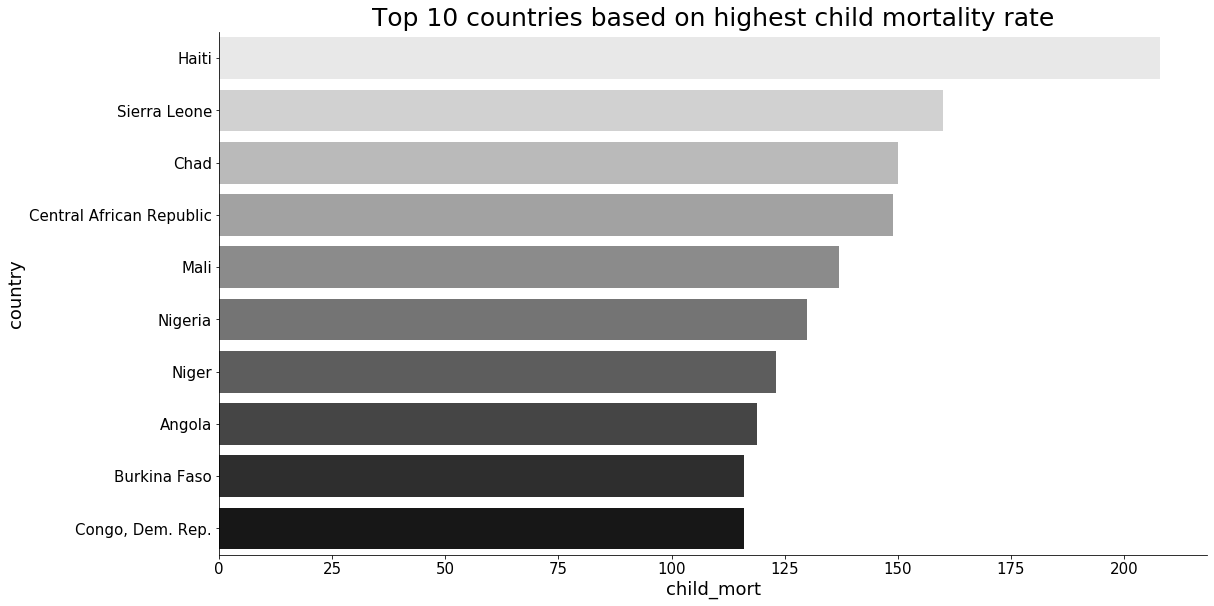

In [13]:
top = df.groupby('country')['child_mort'].sum().reset_index().sort_values(by='child_mort',ascending=False)
bivariate_top('child_mort','country',top,'gray_r','highest child mortality rate')

### 2.2.2 Country VS Total spending on Health

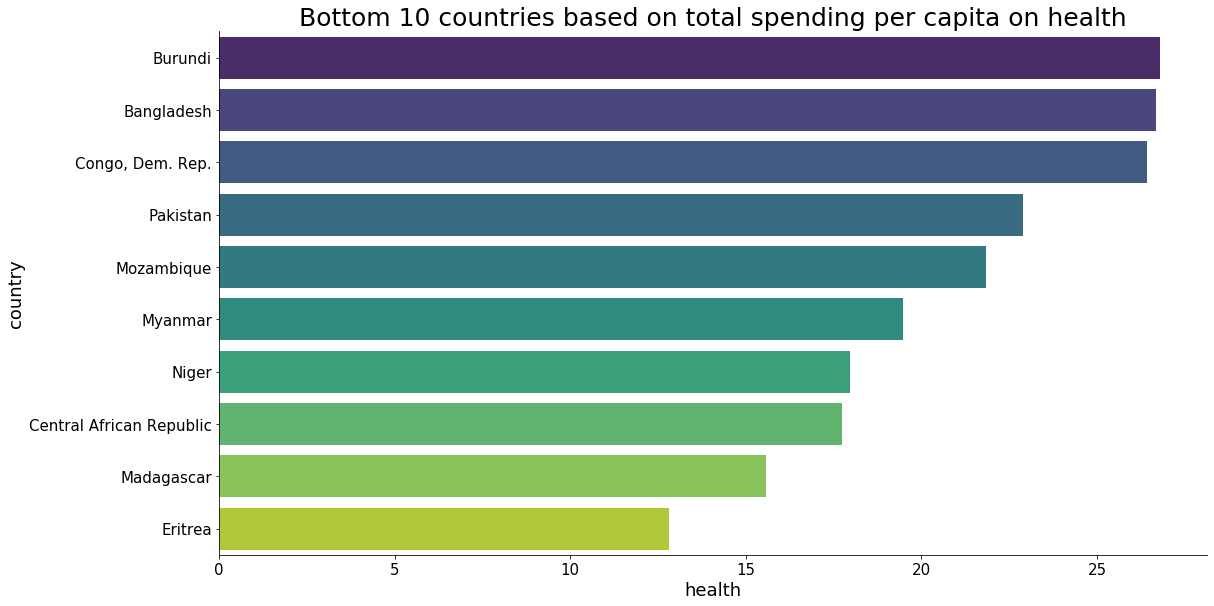

In [14]:
top1 = df.groupby('country')['health'].sum().reset_index().sort_values(by='health',ascending=False)
bivariate_bottom('health','country',top1,'viridis','total spending per capita on health')

### 2.2.3 Country VS Net income

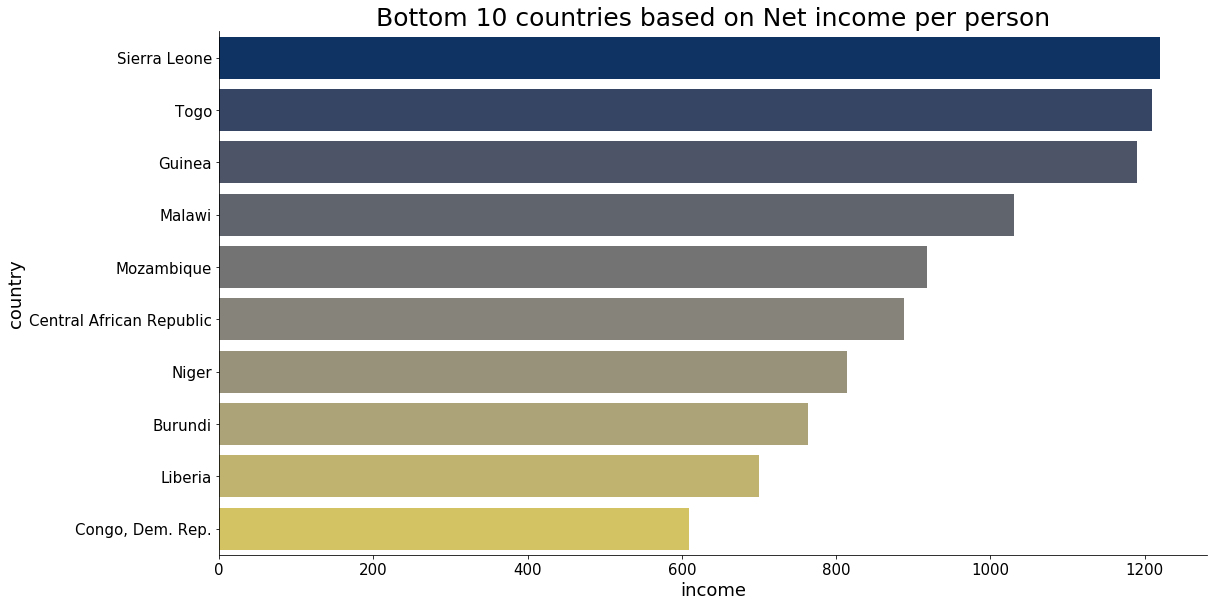

In [15]:
top2 = df.groupby('country')['income'].sum().reset_index().sort_values(by='income',ascending=False)
bivariate_bottom('income','country',top2,'cividis','Net income per person')

### 2.2.4 Country VS GDP per capita

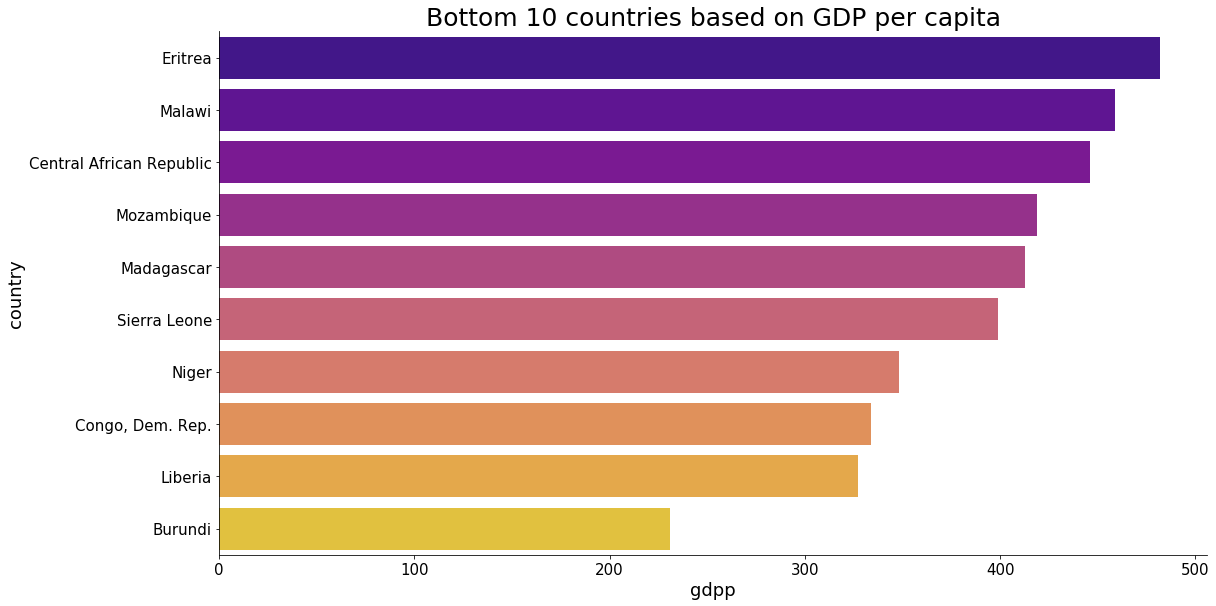

In [16]:
top3 = df.groupby('country')['gdpp'].sum().reset_index().sort_values(by='gdpp',ascending=False)
bivariate_bottom('gdpp','country',top3,'plasma','GDP per capita')

### 2.2.5 Country VS GDP, income and child_mort

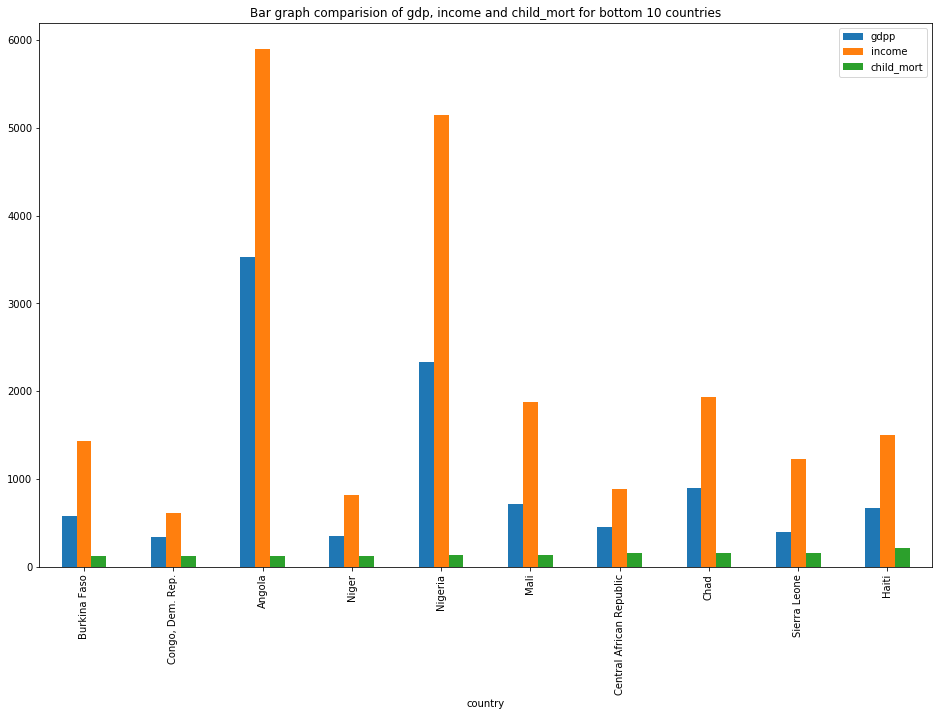

In [17]:
gdpp =df.groupby('country')['gdpp'].sum()
income =df.groupby('country')['income'].sum()
mort =df.groupby('country')['child_mort'].sum()


df1 = pd.concat([gdpp,income,mort], axis=1)
df1.sort_values('child_mort', inplace =True, ascending=True)
df1 = df1.tail(10)

df1.plot(kind='bar')
plt.gcf().set_size_inches(16,10)
plt.title("Bar graph comparision of gdp, income and child_mort for bottom 10 countries")
plt.show()

### 2.2.6 Country VS Export and Import

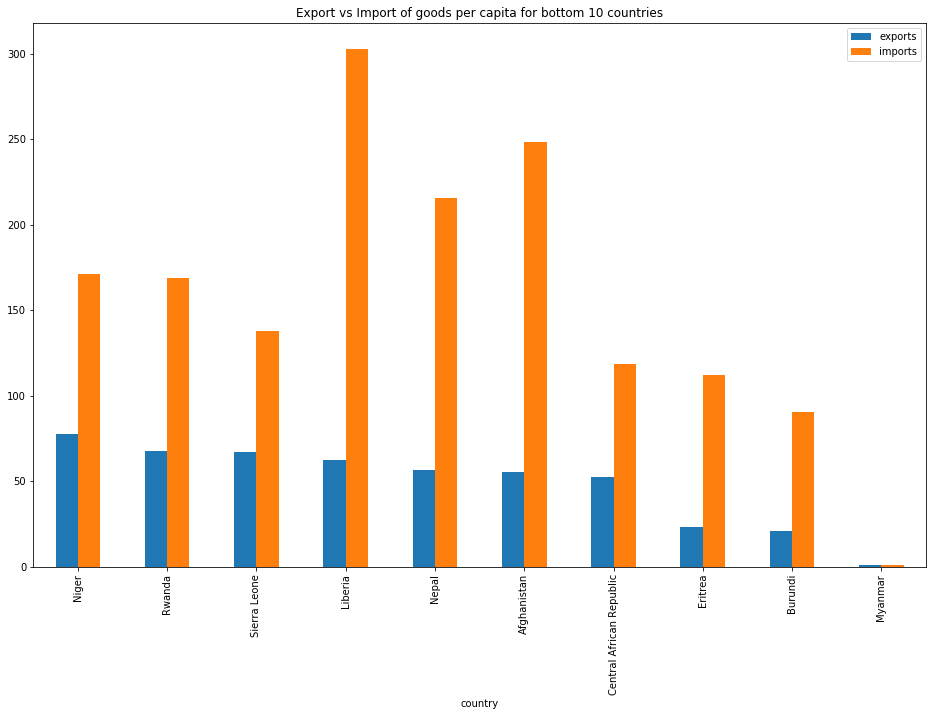

In [18]:
exports =df.groupby('country')['exports'].sum()
imports =df.groupby('country')['imports'].sum()

df1 = pd.concat([exports,imports], axis=1)
df1.sort_values('exports', inplace =True, ascending=False)
df1 = df1.tail(10)

df1.plot(kind='bar')
plt.gcf().set_size_inches(16,10)
plt.title("Export vs Import of goods per capita for bottom 10 countries")
plt.show()

### 2.2.7 Life Expectancy VS child Mortality rate

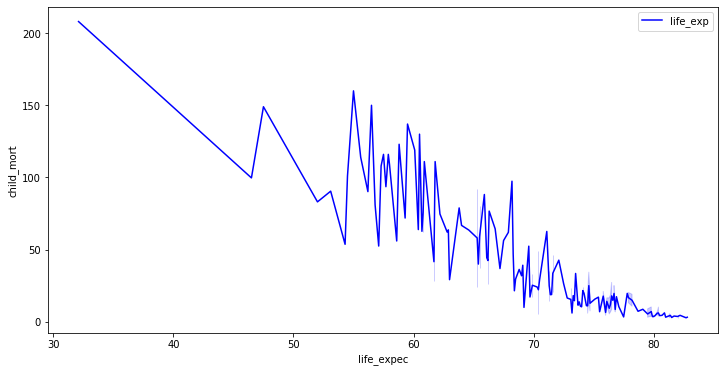

In [19]:
plt.figure(figsize = (12,6))
sns.lineplot('life_expec', 'child_mort', data = df, color = 'b', label= 'life_exp')
plt.legend()
plt.show()

`INFERENCES BASED ON BIVARIATE ANALYSIS:`

1. Haiti has highest child mortality Rate.
2. Madagascar, Eritria are the countries with least total spending per capita on health.
3. Congo, Dem. Rep. is the country with least net income per person.
4. Burundi, Liberiaa are the countries with least GDP per capita.
5. Myanmar has export import in negatives.
6. Life_expectancy is inversly proportional to child_mortality.

# 3. Prepare the data for Clustering

## 3.1 Outlier Treatment

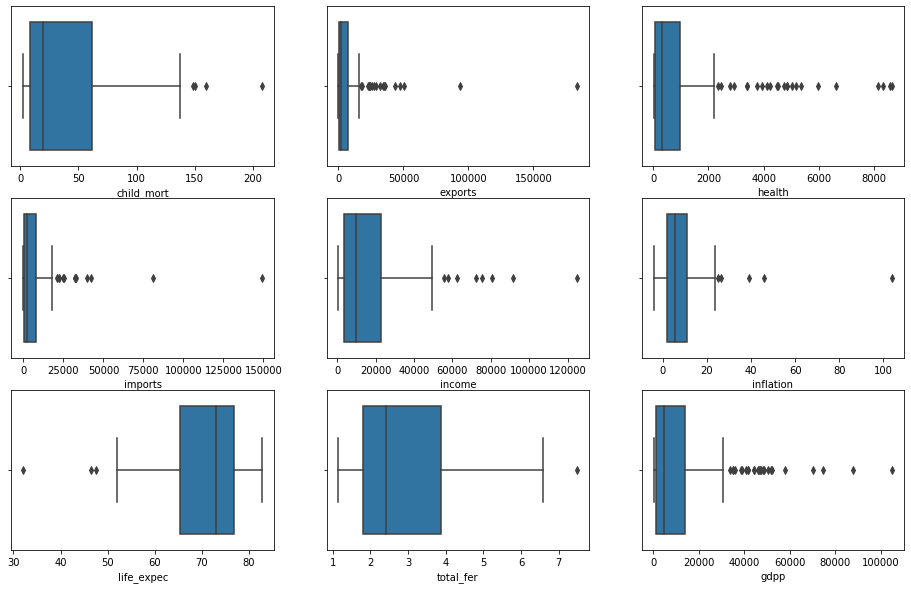

In [20]:
# Plotting boxplots

plt.figure(figsize=(16,10))
f= df.columns[1:]
for i in enumerate(f):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x= i[1], data=df)

We will use capping with **Soft range**

- Child_Mort, Inflation: We are not dealing with upper range outliers but we can deal with lower range outliers.
- But for rest of the columns we will ignore the lower range outliers but we can treat upper range outliers.

In [21]:
# Perform upper range outlier treatment with 0.98 as capping value

f= ['exports','imports','health','gdpp','income']

for i in enumerate(f):
    q3 = df[i[1]].quantile(0.98)
    df[i[1]][df[i[1]]>=q3]=q3


## 3.2 Scaling

In [22]:
#scaling numerical values using Standard Scaler method from sklearn 

ss = StandardScaler()
df1 = ss.fit_transform(df.drop('country', axis = 1))
df1

array([[ 1.29153238, -0.60700492, -0.57845071, ..., -1.61909203,
         1.90288227, -0.72187203],
       [-0.5389489 , -0.5008812 , -0.44726577, ...,  0.64786643,
        -0.85997281, -0.50871936],
       [-0.27283273, -0.44562948, -0.49481806, ...,  0.67042323,
        -0.0384044 , -0.48642179],
       ...,
       [-0.37231541, -0.52054997, -0.5507676 , ...,  0.28695762,
        -0.66120626, -0.67625241],
       [ 0.44841668, -0.57412302, -0.56339163, ..., -0.34463279,
         1.14094382, -0.67625241],
       [ 1.11495062, -0.55979014, -0.55286328, ..., -2.09278484,
         1.6246091 , -0.66721286]])

In [23]:
# Transforming series into Dataframe

df1 = pd.DataFrame(df1)
df1.columns = df.columns[1:]
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.607005,-0.578451,-0.650202,-0.870777,0.157336,-1.619092,1.902882,-0.721872
1,-0.538949,-0.500881,-0.447266,-0.439715,-0.390399,-0.312347,0.647866,-0.859973,-0.508719
2,-0.272833,-0.445629,-0.494818,-0.510783,-0.218918,0.789274,0.670423,-0.038404,-0.486422
3,2.007808,-0.398254,-0.544381,-0.496997,-0.623082,1.387054,-1.179234,2.128151,-0.542467
4,-0.695634,-0.071888,-0.175718,0.189295,0.139056,-0.601749,0.704258,-0.541946,-0.019981


## 3.3 Hopkin's Statistics

The Hopkins statistic, is a method which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.


 If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

 If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster

In [24]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [25]:
hopkins(df1)

0.9096740377712557

**INFERENCE** Based on the Hopkins value which is above 80%, we can perform K Means clustering.

# 4. Cluster Modelling using K-MEANS
___Finding the Optimal Number of Clusters___

### 4.1 Elbow-curve 

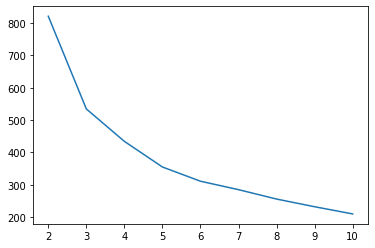

In [26]:
# elbow-curve/SSD
ssd = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k).fit(df1)
    ssd.append([k,kmeans.inertia_])
    
# plot the SSDs for each n_clusters
ssd = pd.DataFrame(ssd)
plt.plot(ssd[0], ssd[1])

### 4.2 Silhouette Analysis

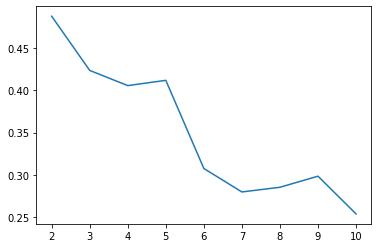

In [27]:
# silhouette analysis

ss = []
for k in range(2,11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmean.labels_)])

sil =pd.DataFrame(ss)
plt.plot(sil[0], sil[1])

`INFERENCE` From the elbow curve and Silhouette analysis, we find that 3 clusters will be optimal

### 4.3 Run KMean with K=3

In [28]:
# final model with k=3
kmeans = KMeans(n_clusters=3, random_state = 0)
kmeans.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [29]:
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [30]:
# assign the label

df['cluster_id'] = kmeans.labels_
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [31]:
# Check the number of Data Points in each cluster

df.cluster_id.value_counts()

0    89
2    48
1    30
Name: cluster_id, dtype: int64

# 5. Visualising the clusters

Plotting the clusters wrt to following variables:
- GDPP
- Income
- Child_Mort

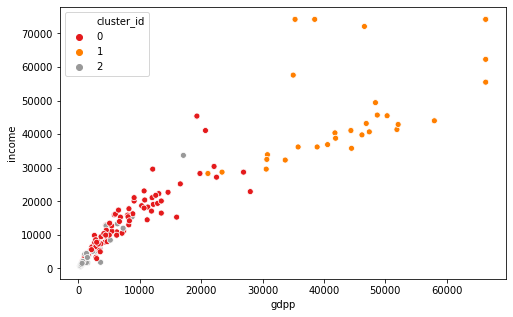

In [32]:
# GDPP vs INCOME

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster_id', data = df, palette ='Set1')
plt.show()

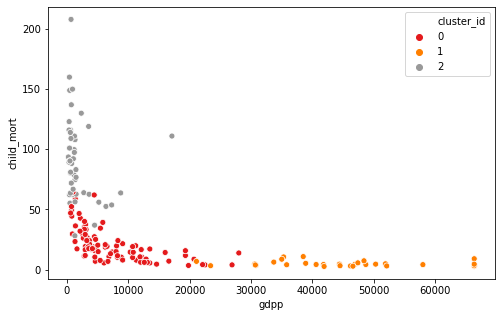

In [33]:
# GDPP vs CHILD_MORT

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'cluster_id', data = df, palette ='Set1')
plt.show()

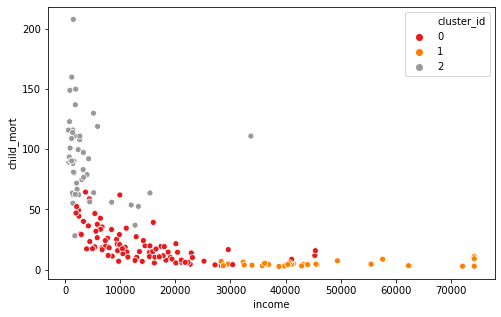

In [34]:
# INCOME vs CHILD_MORT

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'cluster_id', data = df, palette ='Set1')
plt.show()

# 6.Cluster Profiling

We will try to find that cluster for which we have **Low GDPP, Low Income and High Child_Mort**

In [35]:
df[['income', 'gdpp', 'child_mort','cluster_id']].groupby('cluster_id').mean()

,income,gdpp,child_mort
cluster_id,,,
0,13626.853933,7552.494382,20.726966
1,46254.400000,44298.533333,4.970000
2,3897.354167,1909.208333,91.610417


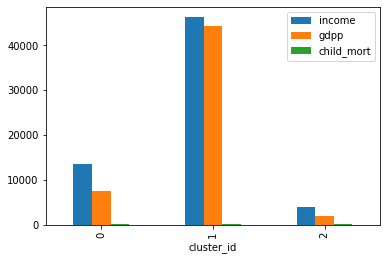

In [36]:
df[['income', 'gdpp', 'child_mort','cluster_id']].groupby('cluster_id').mean().plot(kind='bar')
plt.show()

`INFERENCE: `CLUSTER 2 is our target cluster with Low GDPP, Low Income and High Child_Mort

# Hierarchical Clustering

The steps involved in performing the Hierarchial Clustering are: 
- Need to build the model using 
    - Single Linkage 
    - Complete Linkage
- Select the type of Linkage
- Visualising Clusters
- Cluster Profiling

In [37]:
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.607005,-0.578451,-0.650202,-0.870777,0.157336,-1.619092,1.902882,-0.721872
1,-0.538949,-0.500881,-0.447266,-0.439715,-0.390399,-0.312347,0.647866,-0.859973,-0.508719
2,-0.272833,-0.445629,-0.494818,-0.510783,-0.218918,0.789274,0.670423,-0.038404,-0.486422
3,2.007808,-0.398254,-0.544381,-0.496997,-0.623082,1.387054,-1.179234,2.128151,-0.542467
4,-0.695634,-0.071888,-0.175718,0.189295,0.139056,-0.601749,0.704258,-0.541946,-0.019981


### Single linkage


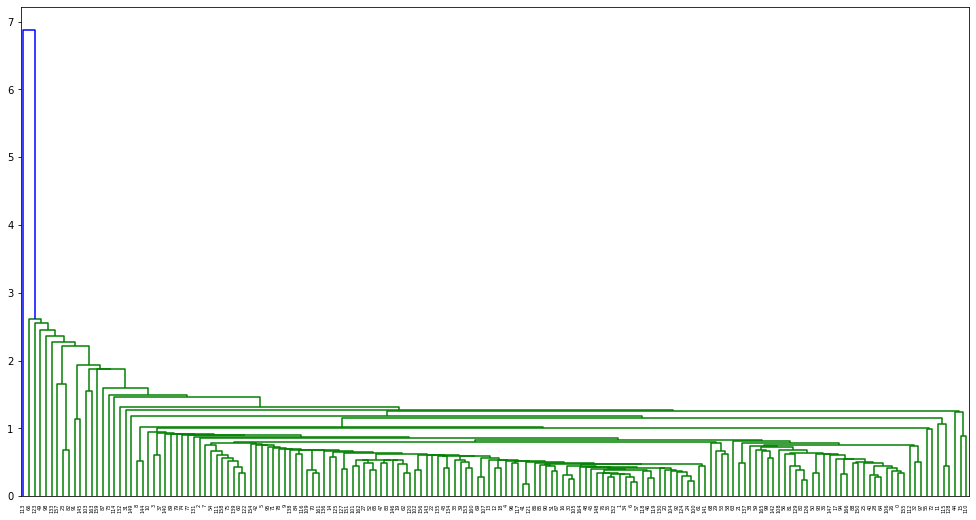

In [38]:
plt.figure(figsize=(17,9))
mergings = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

### Complete linkage

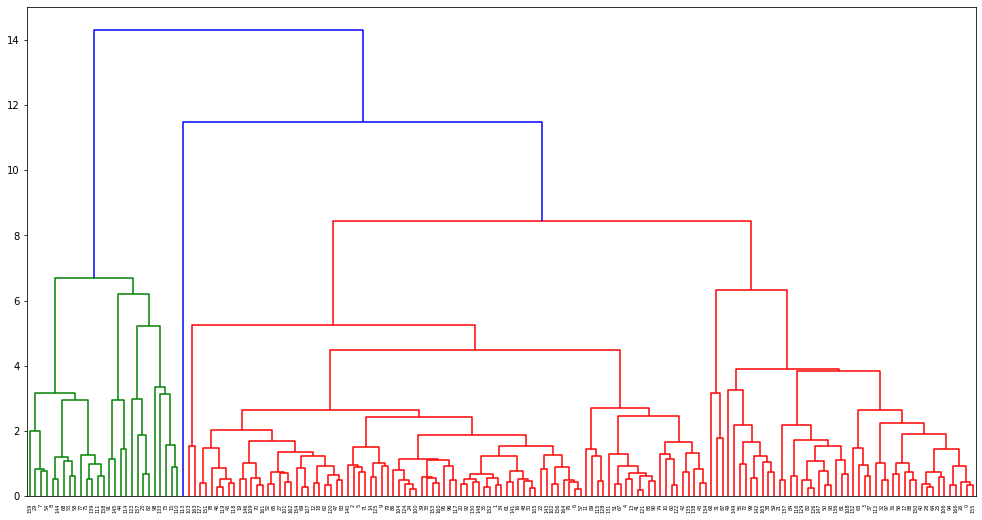

In [39]:
plt.figure(figsize=(17,9))
mergings1 = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings1)
plt.show()

In [40]:
# Using complete linkage to perform final clustering with 3 clusters

cluster_labels = cut_tree(mergings1, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [41]:
# assign cluster labels

df['cluster_labels'] = cluster_labels
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950.0,2.62,63.0,3.50,2970.0,0,0
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500.0,45.90,75.4,2.47,13500.0,0,0
164,Vietnam,23.3,943.20,89.6040,1050.620,4490.0,12.10,73.1,1.95,1310.0,0,0
165,Yemen,56.3,393.00,67.8580,450.640,4480.0,23.60,67.5,4.67,1310.0,2,0


In [42]:
# Check the number of Data Points in each cluster

df.cluster_labels.value_counts()

0    139
1     27
2      1
Name: cluster_labels, dtype: int64

### Plotting the clusters wrt to following variables:

- GDPP
- Income
- Child_Mort

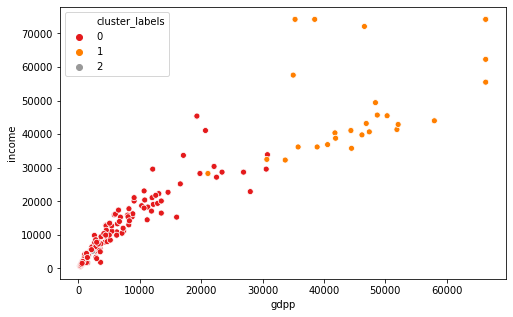

In [43]:
# GDPP vs INCOME

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster_labels', data = df, palette = 'Set1')
plt.show()

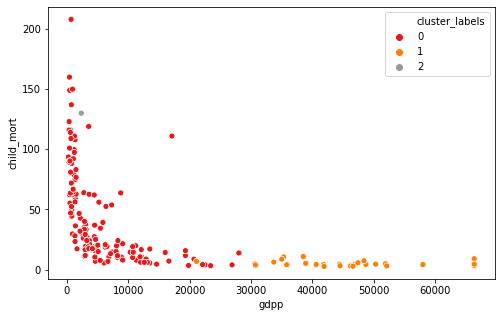

In [44]:
# GDPP vs CHILD_MORT

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'cluster_labels', data = df, palette ='Set1')
plt.show()

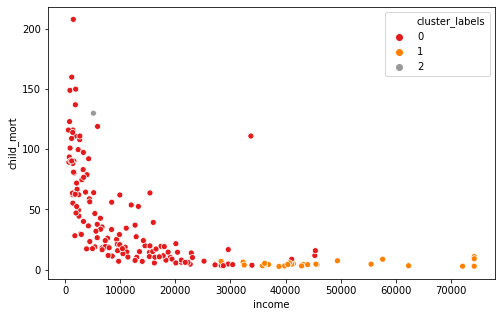

In [45]:
# INCOME vs CHILD_MORT

plt.figure(figsize=(8,5))
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'cluster_labels', data = df, palette ='Set1')
plt.show()

### Cluster Profiling

We will try to find that cluster for which we have **Low GDPP, Low Income and High Child_Mort**

In [46]:
df2= df[['income', 'gdpp', 'child_mort','cluster_labels']].groupby('cluster_labels').mean()
df2

,income,gdpp,child_mort
cluster_labels,,,
0,10697.215827,6088.374101,44.053237
1,47978.962963,46079.851852,5.100000
2,5150.000000,2330.000000,130.000000


CLUSTER 2 is our target cluster with Low GDPP, Low Income and High Child_Mort

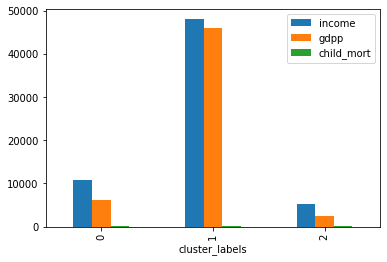

In [47]:
df2.plot(kind='bar')
plt.show()

## Finding the countries who are in direct AID

In [48]:
cluster = df[df['cluster_id']==2]

In [49]:
cluster.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True, False, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,2,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,2,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,2,0


### ASSUMPTIONS


- There is a high imbalance in the Clusters in Hiererachial Clustering, so we are choosing K Means Clustering for finding the top 5 countries that are in need for financial aid. 
- In the K Means Clustering, from the above calculations we have found that Cluster 2 is need for the financial Aid. 

### CONCLUSION

- We have choosen K Means Clustering over the Hierarchial Clustering since the Cluster value counts are better in K Means. 
- Based upon the Cluster IDs in K Means clustering: 
    - Cluster 1 is having the higher mean of GDPP, Income and low Child Mortality 
    - Cluster 0 is having slightly lesser mean of GDPP, Income and little higher Child Mortality 
    - Cluster 2 is having very less mean of GDPP, Income and very high Child Mortality
- We are choosing Cluster 2 based on the mean values. 

### SUGGESTIONS

- The Countries which are in need for the financial aid are: 
    - Burundi
    - Liberia
    - Congo, Dem. Rep.
    - Niger
    - Sierra Leone
    
- These countries are having Low GDPP, Low Income and High Child Mortality. 
